# Transformers

# part a
SECTION 1: Implementing a Transformer Model and Analyzing Temperature
Effects
- Implement a basic Transformer model from scratch using PyTorch.
- Generate outputs from your model by varying the temperature parameter. Use the following
temperature values:
  - T<1 (e.g., 0.5)
  - T=1
  - T>1 (e.g., 1.5 or 2)
- Analyze how changing the temperature affects the output

## import libraries


In [1]:
import re
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd

## prepare dataset

fisrt download the dataset from [this link](https://projectquest.ir/Transformers_for_Pattern_Recognition/hw3.txt)

In [2]:
!gdown 12U3zFsY2vuaiwKbDfR4V7M7tgynBHG7_

Downloading...
From: https://drive.google.com/uc?id=12U3zFsY2vuaiwKbDfR4V7M7tgynBHG7_
To: j:\Seventh Semester\Deep Learning\Workshops\Workshop6\dataset.txt

  0%|          | 0.00/3.23M [00:00<?, ?B/s]
 16%|█▌        | 524k/3.23M [00:00<00:04, 616kB/s]
 32%|███▏      | 1.05M/3.23M [00:01<00:02, 940kB/s]
 49%|████▊     | 1.57M/3.23M [00:01<00:01, 876kB/s]
 65%|██████▍   | 2.10M/3.23M [00:02<00:01, 814kB/s]
 81%|████████  | 2.62M/3.23M [00:03<00:00, 788kB/s]
 97%|█████████▋| 3.15M/3.23M [00:03<00:00, 789kB/s]
100%|██████████| 3.23M/3.23M [00:03<00:00, 819kB/s]


then we should read the dataset

In [2]:
# read it in to inspect it
file_path = "dataset.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
print("dataset length: ", len(text))

dataset length:  3204487



In this section, we should identify all unique Letters.

In [4]:
# here are all the unique letters that occur in this text
##############################
letters = set(text)
letters_size = len(letters)
##############################
print("".join(letters))
print(letters_size)

TnhYl;Zyzv)w(0rWSM-DoGR﻿XdV 
P/9UiN:LAtaxqO*Fus.75CQ4EHmp!f'"eB2g3kbj8J1I=K,6c?
79


In this section, we will perform three tasks:


1.   replace every hyphen in text with a space.
2.   define a regex pattern and use it to filter the text with the `re` library. With this pattern, you should be able to replace all characters except letters, numbers, dots, and newline characters (eg:* and !) with nothing.
3. detect lines and words in text

***Note: each line will end with a dot.***


In [5]:
###############################
# Your code here (~ 10 lines) #
###############################
text = text.replace("-", " ")
pattern1 = r"[^a-zA-Z0-9.\n\s]"
pattern2 = r"[.]"
pattern3 = r"[\n+]"
text = re.sub(pattern1, " ", text)
text = re.sub(pattern3, " ", text)
words = set(re.sub(pattern2, " ", text.lower()).split())
lines = [line.replace("\n", "") for line in text.split(".")]

In [6]:
vocab_size = len(words)
print("Total no. of lines: ", len(lines))
print("Total unique words: ", len(words))

Total no. of lines:  30588
Total unique words:  17543


In this part, we create two dictionaries for mapping from words to integers and vice versa.

***Note: Here, rather than assigning a one-hot vector to each word, which can be sparse, we assign a single number to represent the word. This approach helps in better understanding the outputs.***


In [7]:
# Mapping from words to integers and vice versa
##############################
itos = {word: i for i, word in enumerate(words)}
itos_rev = {i: word for i, word in enumerate(words)}
##############################
print(len(itos))

17543


17877

Now, we should create encoder and decoder:


*   encoder: take a string, output a list of integers
*   decoder: take a list of integers, output a string



In [8]:
##############################
# Your code here (~ 2 lines) #
##############################
def encode(text):
    integer_list = []
    for word in text.lower().split():
        integer_list.append(itos[word])

    return integer_list


def decode(integer_list):
    text = []
    for num in integer_list:
        text.append(itos_rev[num])

    return " ".join(text)


print(encode("you are a teacher"))
print(decode(encode("you are a teacher")))

[1908, 13965, 11737, 13479]
you are a teacher


Now, we should convert our data to tensor and split it into training and validation sets.

In [9]:
##############################
data = (
    torch.Tensor([encode(word) for word in " ".join(lines).split()])
    .to(dtype=torch.int64)
    .squeeze()
)
##############################


print(data.shape, data.dtype)

torch.Size([572546]) torch.int64


torch.Size([596551]) torch.int64

In [10]:
# Let's now split up the data into train and validation sets
n = int(0.9 * len(data))  # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [11]:
train_data[50 : 55 + 1]

tensor([10515,  1018, 15234,  5509, 17513,  8977])

## define our task

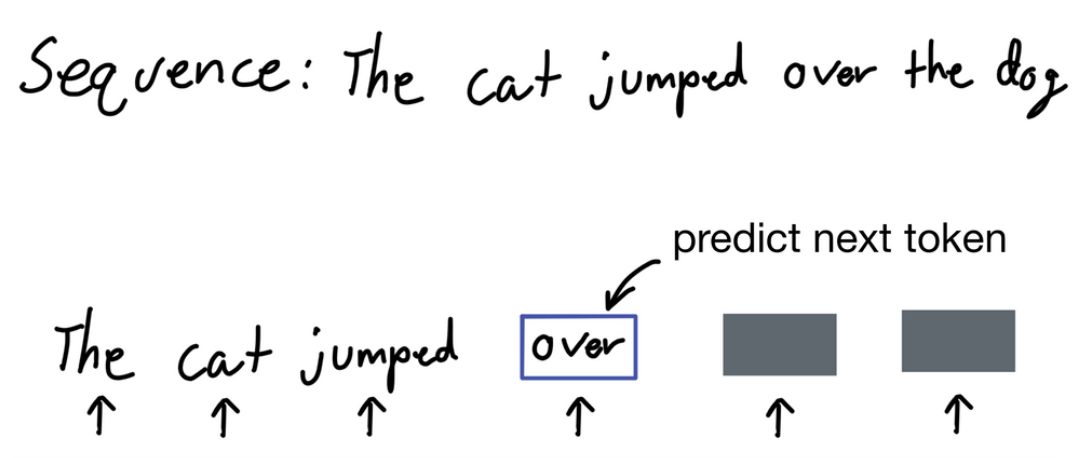

In [12]:
x = train_data[50:55]
y = train_data[51:56]
for t in range(5):
    context = x[: t + 1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([10515]) the target: 1018
when input is tensor([10515,  1018]) the target: 15234
when input is tensor([10515,  1018, 15234]) the target: 5509
when input is tensor([10515,  1018, 15234,  5509]) the target: 17513
when input is tensor([10515,  1018, 15234,  5509, 17513]) the target: 8977


when input is tensor([41]) the target: 42
when input is tensor([41, 42]) the target: 43
when input is tensor([41, 42, 43]) the target: 29
when input is tensor([41, 42, 43, 29]) the target: 44
when input is tensor([41, 42, 43, 29, 44]) the target: 45

In [13]:
torch.manual_seed(1337)
batch_size = 4  # how many independent sequences will we process in parallel?
n_context = 8  # what is the maximum context length for predictions?
device = "cuda" if torch.cuda.is_available() else "cpu"


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    # Note: Use the training data when split=train, and the validation data otherwise.
    ##############################
    data = train_data if split == "train" else val_data
    end_index = len(data) - 1
    random_points = torch.add(
        torch.randint(end_index - n_context, (batch_size, 1)),
        torch.Tensor([0, n_context]),
    ).to(dtype=torch.int64)

    train_split = [
        data[start.item() : end.item()].unsqueeze(dim=0)
        for _, (start, end) in enumerate(random_points)
    ]
    val_split = [
        data[start.item() + 1 : end.item() + 1].unsqueeze(dim=0)
        for _, (start, end) in enumerate(random_points)
    ]

    x = torch.cat(
        tuple(train_split),
        dim=0,
    )
    y = torch.cat(
        tuple(val_split),
        dim=0,
    )
    ##############################
    return x, y


xb, yb = get_batch("train")
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)

print("----")

for b in range(batch_size):  # batch dimension
    for t in range(n_context):  # time dimension
        context = xb[b, : t + 1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[11737,  2602,  2272,  5101, 11737, 16777, 16954,  4240],
        [ 2272,  2918,  2259,  4880,  6289, 10515,  1241, 16335],
        [14284,   949, 17369, 15173,  6504,   939, 16643, 16954],
        [ 2916,  4089, 16727, 14470, 13321, 16811, 16727, 11275]])
targets:
torch.Size([4, 8])
tensor([[ 2602,  2272,  5101, 11737, 16777, 16954,  4240, 10678],
        [ 2918,  2259,  4880,  6289, 10515,  1241, 16335, 14644],
        [  949, 17369, 15173,  6504,   939, 16643, 16954, 16727],
        [ 4089, 16727, 14470, 13321, 16811, 16727, 11275, 13671]])
----
when input is [11737] the target: 2602
when input is [11737, 2602] the target: 2272
when input is [11737, 2602, 2272] the target: 5101
when input is [11737, 2602, 2272, 5101] the target: 11737
when input is [11737, 2602, 2272, 5101, 11737] the target: 16777
when input is [11737, 2602, 2272, 5101, 11737, 16777] the target: 16954
when input is [11737, 2602, 2272, 5101, 11737, 16777, 16954] the target: 4240
wh

## self-attention review

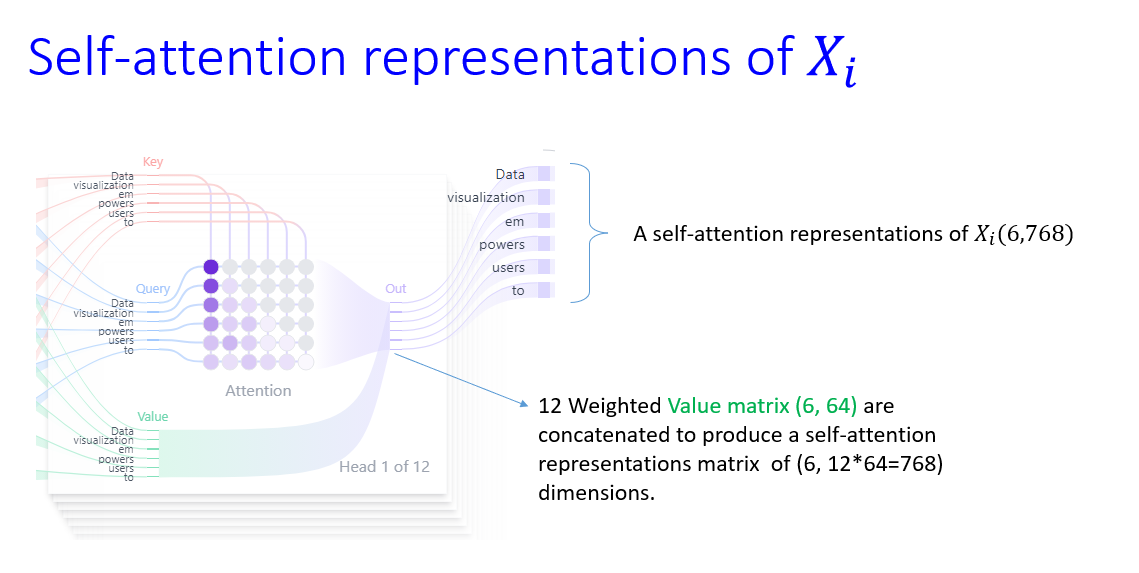

In [14]:
torch.manual_seed(1337)
batch_size, n_context, d_model = 1, 6, 768  # batch, n_context, d_model
x = torch.randn(batch_size, n_context, d_model)

print("x dimention is: ", x.shape)
# let's see a single Head perform self-attention
head_size = 64
number_of_heads = d_model / head_size

key = nn.Linear(d_model, head_size)
query = nn.Linear(d_model, head_size)
value = nn.Linear(d_model, head_size)
k = key(x)
q = query(x)

print("Query dimention (Head 1 of 12) is: ", q.shape)
print("Key dimention (Head 1 of 12) is: ", k.shape)

x dimention is:  torch.Size([1, 6, 768])
Query dimention (Head 1 of 12) is:  torch.Size([1, 6, 64])
Key dimention (Head 1 of 12) is:  torch.Size([1, 6, 64])


## Mask in attention review

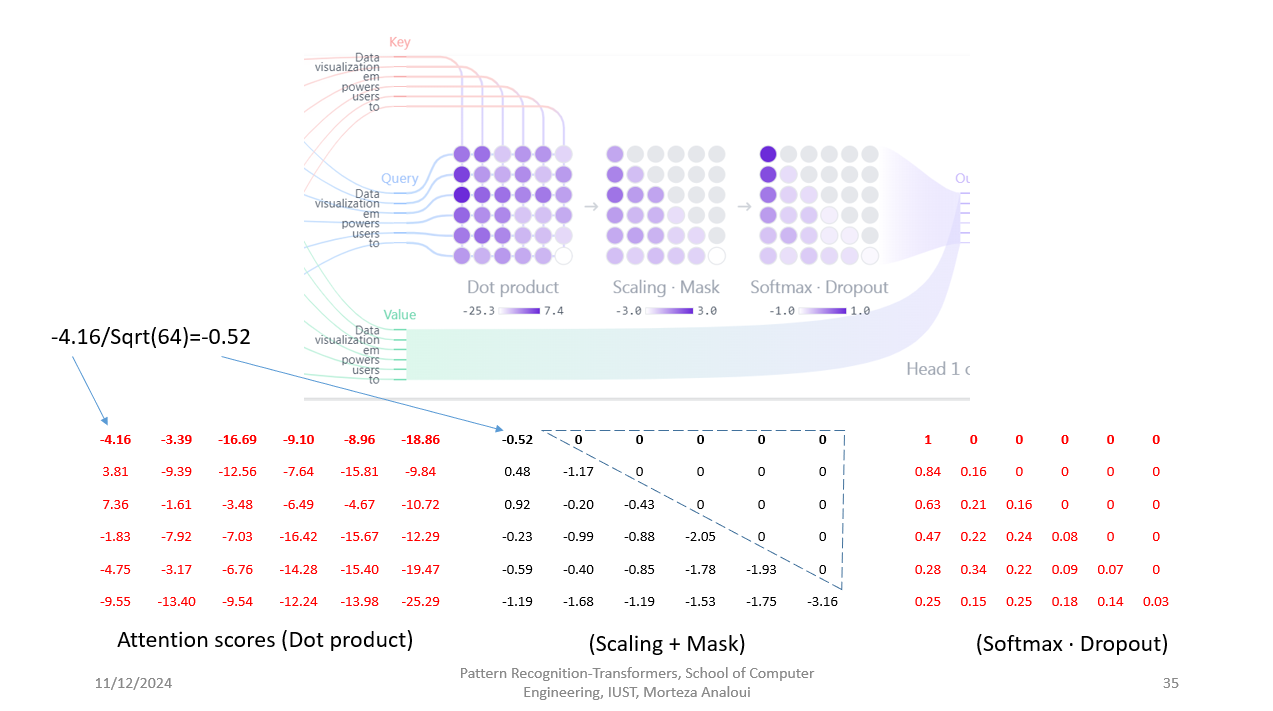

In [15]:
torch.manual_seed(1337)
batch_size, n_context, d_model = 1, 6, 768  # batch, n_context, d_model
x = torch.randn(batch_size, n_context, d_model)

print("x dimention is: ", x.shape)
# let's see a single Head perform self-attention
head_size = 64
number_of_heads = d_model / head_size

key = nn.Linear(d_model, head_size)
query = nn.Linear(d_model, head_size)
value = nn.Linear(d_model, head_size)
k = key(x)
q = query(x)

wei = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(head_size))

print("Dot product: \n", wei)
print("-" * 80)
mask = torch.tril(torch.ones(wei.size())).unsqueeze(0).unsqueeze(0)

# now fill mask with our attention scores

wei = wei.masked_fill(mask == 0, value=float("-inf"))
print("(Scaling + Mask): \n", wei)
print("-" * 80)

wei = F.softmax(wei, dim=-1)
print("Softmax: \n", wei)
print("-" * 80)
v = value(x)
print("Value dimention (head 1 of 12) is: ", v.shape)

x dimention is:  torch.Size([1, 6, 768])
Dot product: 
 tensor([[[ 0.3800,  0.6143,  0.0833, -0.1909,  0.1481,  0.2439],
         [-0.5229, -0.0697, -0.2103,  0.0808, -0.2678,  0.4199],
         [-0.3993, -0.0130,  0.1208, -0.2417,  0.0289, -0.2532],
         [-0.0838,  0.2901,  0.3266, -0.3544, -0.1545,  0.0538],
         [-0.2052, -0.2297, -0.3873,  0.0915,  0.0610, -0.4087],
         [-0.5470, -0.2720, -0.1264, -0.2129, -0.3762,  0.3054]]],
       grad_fn=<DivBackward0>)
--------------------------------------------------------------------------------
(Scaling + Mask): 
 tensor([[[[[ 0.3800,    -inf,    -inf,    -inf,    -inf,    -inf],
           [-0.5229, -0.0697,    -inf,    -inf,    -inf,    -inf],
           [-0.3993, -0.0130,  0.1208,    -inf,    -inf,    -inf],
           [-0.0838,  0.2901,  0.3266, -0.3544,    -inf,    -inf],
           [-0.2052, -0.2297, -0.3873,  0.0915,  0.0610,    -inf],
           [-0.5470, -0.2720, -0.1264, -0.2129, -0.3762,  0.3054]]]]],
       grad_fn

## Normalization review

In [16]:
class LayerNorm1d:  # (used to be BatchNorm1d)

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        ##############################
        mean = x.mean(dim=1, keepdim=True)
        vars = x.var(dim=1, keepdim=True)
        x_mean = (x - mean) / torch.sqrt(vars + self.eps)
        self.out = self.gamma * x_mean + self.beta
        ##############################
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100)  # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [17]:
x[:, 0].mean(), x[:, 0].std()  # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [18]:
x[0, :].mean(), x[
    0, :
].std()  # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

## implement transformer

Now, we implement transformer completely

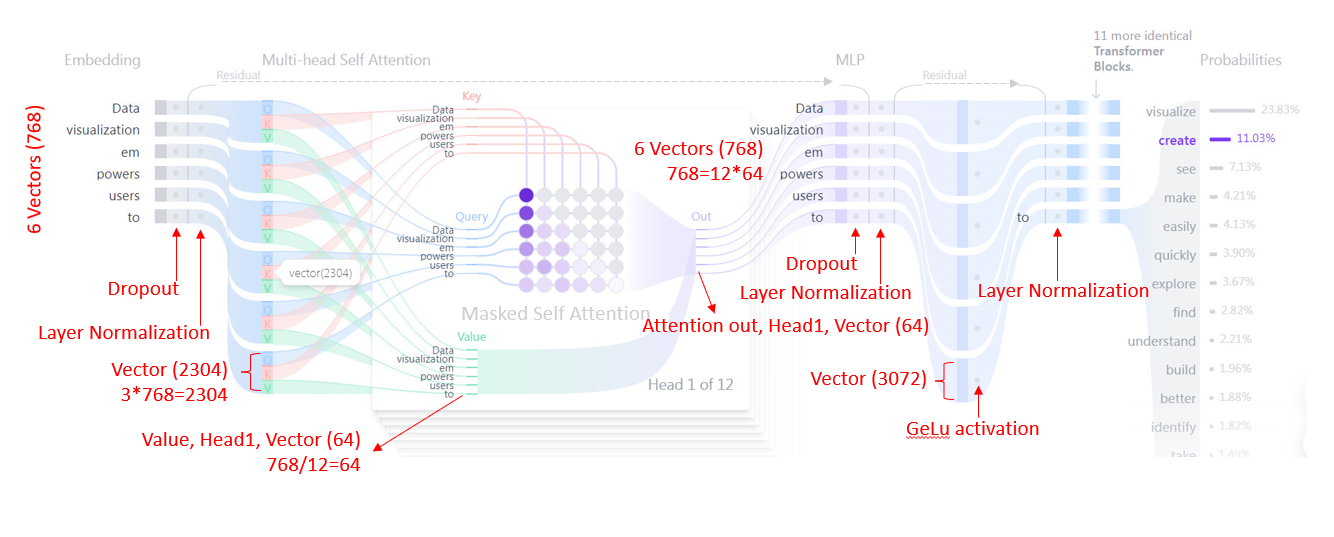

<font color="orange"><h3> Use three different Temperature hyperparameters (smaller than one - one -
Greater than one) </h3> </font>

In [ ]:
# @title Temperature hyperparameter
Temperature = 1  # @param {type:"slider", min:0, max:10, step:0.1}

In [ ]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
n_context = 256 # what is the maximum context length for predictions?
max_iters = 1500
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
d_model = 768
n_head = 12
n_layer = 12
dropout = 0.0
# ------------

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # Complete this section with the help of the codes we wrote above - Define key, query, value, mask and dropout -
        # Note: your mask must be a register_buffer because it is not trained by the optimizer and the optimizer won’t have a change to update them.
        ##############################
        # Your code here (~ 5 lines) #
        ##############################
    def forward(self, x):
        batch_size, n_context, d_model = x.shape
        # Complete this section with the help of the codes we wrote above
        # Note1: You must normalize attention scores
        # Note2: After calculating the attention score, use Dropout
        # Note3: Use Gelu as activation function
        ##############################
        # Your code here (~ 8 lines) #
        ##############################
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = # Your code here (~ 1 line) #
        self.proj = # Your code here (~ 1 line) #
        self.dropout = # Your code here (~ 1 line) #

    def forward(self, x):
        ##############################
        # Your code here (~ 2 lines) #
        ##############################
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d_model):
        super().__init__()
        # Note1: Use Sequential for creating the net
        # hint: Your hidden layer should be 4 * d_model (Refer to the lesson slides)
        self.net = # Your code here #

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d_model, n_head):
        super().__init__()
        # Define MultiHeadAttention, FeedForward and two LayerNorm (after MultiHeadAttention and after FeedForward)
        ##############################
        # Your code here (~ 2 lines) #
        ##############################

    def forward(self, x):
        ##############################
        # Your code here (~ 2 lines) #
        ##############################
        return x

# super simple bigram model
class TransformerModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Define token embeding, position embedding, blocks, LayerNorm and nonlinearity
        ##############################
        # Your code here (~ 5 lines) #
        ##############################

    def forward(self, idx, targets=None):
        # Note: Use cross entropy as the loss function
        ###############################
        # Your code here (~ 15 lines) #
        ###############################

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last n_context tokens
            idx_cond = idx[:, -n_context:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
model = TransformerModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()) / 1e6, "M parameters")

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(
            f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

# Part B

### Introduction to Transfer Learning

**Transfer learning** is a machine learning technique where a model trained on one task is adapted or fine-tuned to perform a different but related task. Instead of training a model from scratch, transfer learning leverages the knowledge gained from a source domain (pre-training) and applies it to a target domain (fine-tuning). This approach is particularly beneficial when the target domain has limited labeled data, as it reduces training time and improves model performance by building on learned features from the source domain.

In computer vision, transfer learning often involves using pre-trained models on large-scale datasets (like ImageNet) and fine-tuning them for specific tasks such as object detection, image classification, or segmentation.



### Problem Definition: Noisy Bird Classification Using Self-Supervised Learning and Fine-Tuned Swin Transformer

---

#### **Background**
The task of classifying images of birds into predefined categories is a fundamental problem in computer vision with applications in biodiversity monitoring, conservation, and ornithology research. The challenge becomes more complex when working with **noisy datasets**, where:
1. **Unlabeled data** is abundant but lacks annotations.
2. **Labeled data** is limited and may include class imbalances or variability in image quality.

A robust classification model must leverage the unlabeled data effectively while generalizing well to the labeled data for accurate predictions.

---

#### **Objective**
To develop an efficient pipeline for bird image classification by addressing the following key challenges:
1. Utilize **unlabeled data** through self-supervised learning (SSL) to pre-train the model on a rotation-prediction task.
2. Fine-tune the pre-trained model on a **limited labeled dataset** for the final classification task.

The primary aim is to maximize classification accuracy on the labeled dataset by exploiting self-supervised pre-training.

---

#### **Scope**
The problem consists of two distinct but interlinked tasks:
1. **Self-Supervised Learning (SSL):** Train a Swin Transformer model to predict the rotation angle (0°, 90°, 180°, 270°) applied to unlabeled images, enabling the model to learn generalizable image features.
2. **Fine-Tuning:** Transfer the learned features to a supervised classification task, fine-tuning the model on the labeled dataset for classifying bird species.

This approach ensures that the model extracts meaningful features from the unlabeled dataset, which helps improve performance on the labeled dataset.

---

#### **Challenges**
1. **Unlabeled Data Utilization:** How to effectively use the large volume of unlabeled images for meaningful feature extraction.
2. **Limited Labeled Data:** Mitigating overfitting while fine-tuning on a relatively small labeled dataset.
3. **Feature Representation:** Leveraging the Swin Transformer architecture, which has proven effective for visual tasks but requires adaptation for SSL.
4. **Evaluation and Visualization:** Measuring the model's performance effectively and ensuring interpretability through visualizations.

---

### Transfer Learning in This Problem

In this problem, transfer learning is implemented in two key stages:

#### 1. **Self-Supervised Pre-Training (Source Task)**
   - **Objective**: Pre-train the Swin Transformer model on a **self-supervised learning (SSL) task** using unlabeled bird images.
   - **SSL Task**: The model is trained to predict the rotation angle (0°, 90°, 180°, 270°) applied to the input images. This task forces the model to learn general visual features, such as edges, textures, and patterns, which are useful for image understanding.
   - **Importance for Transfer Learning**:
     - Since the dataset is unlabeled, this step leverages self-supervision to extract meaningful features from the data without requiring manual annotations.
     - These learned features serve as a strong initialization point for downstream tasks, reducing the need for extensive labeled data.

---

#### 2. **Fine-Tuning on Labeled Dataset (Target Task)**
   - **Objective**: Fine-tune the pre-trained Swin Transformer model on a labeled dataset to classify bird images into specific categories.
   - **Transfer Process**:
     - The model’s pre-trained weights from the SSL stage are loaded and adapted to a new classification head designed for the target task (bird species classification).
     - The fine-tuning process adjusts the model parameters to specialize in the labeled dataset while preserving general features learned during pre-training.
   - **Importance**:
     - Fine-tuning builds upon the robust feature representations learned in the SSL stage, leading to faster convergence and improved accuracy on the labeled dataset.
     - This approach effectively addresses the challenge of having limited labeled data by leveraging the unlabeled dataset for pre-training.


---

#### **Results**
1. **Self-Supervised Learning (SSL):**
   - Achieved a steady decrease in rotation prediction loss over epochs, indicating successful feature learning.

2. **Fine-Tuning:**
   - Improved classification accuracy on labeled data due to the transfer of robust feature representations from the SSL stage.
   - Visualized class predictions for randomly selected samples to verify correctness and interpretability.

3. **Visualization and Metrics:**
   - Provided detailed loss and accuracy plots for both SSL and fine-tuning stages.
   - Demonstrated the model's predictions alongside actual labels for qualitative evaluation.


---


### Benefits of Transfer Learning in This Problem
1. **Improved Generalization**: Pre-training helps the model learn domain-specific features (e.g., bird shapes, patterns, and textures) that enhance performance on the target task.
2. **Reduced Overfitting**: Fine-tuning on the labeled dataset starts with strong initial features, reducing the risk of overfitting, especially given the small size of the labeled dataset.
3. **Efficient Training**: By reusing pre-trained weights, training time and computational costs are significantly reduced compared to training from scratch.


In [191]:
!gdown 1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz

Downloading...
From: https://drive.google.com/uc?id=1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz
To: j:\Seventh Semester\Deep Learning\Workshops\Workshop6\Noisy_birds.zip

  0%|          | 0.00/7.98M [00:00<?, ?B/s]
  7%|▋         | 524k/7.98M [00:00<00:13, 573kB/s]
 13%|█▎        | 1.05M/7.98M [00:07<00:56, 122kB/s]
 20%|█▉        | 1.57M/7.98M [00:08<00:34, 186kB/s]
 26%|██▋       | 2.10M/7.98M [00:09<00:23, 249kB/s]
 33%|███▎      | 2.62M/7.98M [00:10<00:15, 343kB/s]
 39%|███▉      | 3.15M/7.98M [00:10<00:11, 439kB/s]
 46%|████▌     | 3.67M/7.98M [00:11<00:08, 532kB/s]
 53%|█████▎    | 4.19M/7.98M [00:11<00:06, 618kB/s]
 59%|█████▉    | 4.72M/7.98M [00:12<00:05, 651kB/s]
 66%|██████▌   | 5.24M/7.98M [00:12<00:03, 765kB/s]
 72%|███████▏  | 5.77M/7.98M [00:13<00:02, 801kB/s]
 79%|███████▉  | 6.29M/7.98M [00:14<00:02, 833kB/s]
 85%|████████▌ | 6.82M/7.98M [00:14<00:01, 858kB/s]
 92%|█████████▏| 7.34M/7.98M [00:15<00:00, 874kB/s]
 99%|█████████▊| 7.86M/7.98M [00:15<00:00, 901kB/s]
100%|██████████|

In [46]:
!unzip -qo Noisy_birds.zip -d ./Noisy_birds/

In [39]:
!mkdir /content/Noisy_birds/labeled

In [41]:
import os
import shutil

In [48]:
os.makedirs('.\\content\\Noisy_birds\\labeled',exist_ok=True)

In [49]:
source_paths = [
    './Noisy_birds/budgie',
    './Noisy_birds/canary',
    './Noisy_birds/duckling',
    './Noisy_birds/rubber duck'
]

destination_path = './content/Noisy_birds/labeled'

for source in source_paths:
    shutil.move(source, destination_path)

In [ ]:
!mv /content/Noisy_birds/budgie /content/Noisy_birds/labeled
!mv /content/Noisy_birds/canary /content/Noisy_birds/labeled
!mv /content/Noisy_birds/duckling /content/Noisy_birds/labeled
!mv '/content/Noisy_birds/rubber duck' /content/Noisy_birds/labeled

In [51]:
import os
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from transformers import SwinForImageClassification, SwinConfig

In [59]:
data_path = ".\\content\\Noisy_birds"
labeled_path = os.path.join(data_path, "labeled")
unlabeled_path = os.path.join(data_path, "unlabeled")

batch_size = 2
epochs_ssl = 10
epochs_ft = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
class RandomRotationFixed:
    """
    A custom data augmentation utility designed to apply random rotations to an image.
    """

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(img, angle)

In [54]:
ssl_transform = transforms.Compose(
    [
        RandomRotationFixed([0, 90, 180, 270]),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


ft_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [110]:
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = transforms.ToPILImage()(plt.imread(image_path))

        # Randomly select one value from the list [0, 90, 180, 270]
        angle = random.choice([0, 90, 180, 270])
        rotated_image = transforms.functional.rotate(image, angle)

        # Map list [0, 90, 180, 270] to [0, 1, 2, 3] as class indeces
        label = angle // 90

        if self.transform:
            rotated_image = self.transform(rotated_image)

        return rotated_image, label

In [72]:
class LabeledDataSet(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.img_label = []
        for label in os.listdir(path):
            self.img_label.extend(
                [(os.path.join(path, label,imgpath), label) for imgpath in os.listdir(os.path.join(path, label))]
            )
            
        self.class_to_idx = {
            idx:label for idx, label in enumerate(os.listdir(path))
        }

    def __len__(self):
        return len(self.img_label)

    def __getitem__(self, index):
        imgpath, label = self.img_label[index]
        image = transforms.ToPILImage()(plt.imread(imgpath))
        if self.transform:
            image = self.transform(image)

        return image, label

In [111]:
# Create a rotation dataset for SSL
unlabeled_dataset = RotationDataset(unlabeled_path, ssl_transform)
# Create a data loader of unlabeled dataset, set batch size to batch_size and do shuffle
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)


# Load image datasets that are organized in a specific folder structure where:
# 1. Each subfolder corresponds to a class label.
# 2. The images in a subfolder belong to that class
labeled_dataset = LabeledDataSet(labeled_path, ft_transform)
indices = list(range(len(labeled_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create a subset of a dataset by selecting specific data samples (images and their corresponding labels) based on the indices provided
train_dataset = Subset(labeled_dataset, train_indices)
val_dataset = Subset(labeled_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imsho

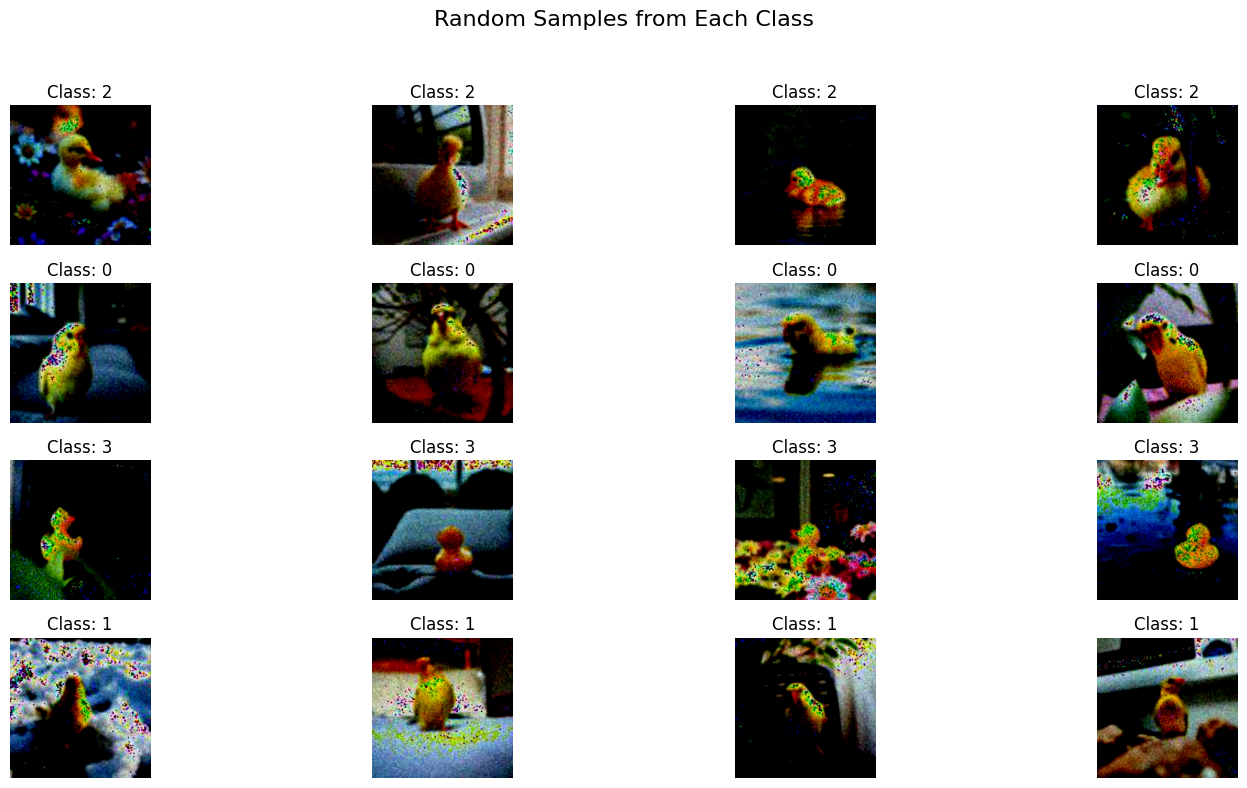

In [90]:
class_to_idx = labeled_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

images_per_class = {}
for idx in range(len(val_dataset)):
    image, label = val_dataset[idx]
    class_name = idx_to_class[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = []
    if len(images_per_class[class_name]) < 4:
        images_per_class[class_name].append((image, class_name))
    if all(len(images) == 4 for images in images_per_class.values()):
        break

fig, axes = plt.subplots(len(images_per_class), 4, figsize=(16, 8))

for row, (class_name, images) in enumerate(images_per_class.items()):
    for col, (image, label) in enumerate(images):
        ax = axes[row, col]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Class: {label}")
        ax.axis("off")

plt.suptitle("Random Samples from Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [101]:
'''
set up and configure a Swin Transformer model for image classification tasks.
modify the model for a self-supervised learning (SSL) task.

Steps:
1. Creating a model configuration: This defines the model's architecture settings.
2. Initializing the Swin Transformer model for image classification using the default configuration.
3. Modifying the model's final layer to output 4 classes, adapting the model to a specific task with 4 output categories.
4. Moving the model to the specified device.
'''

config = SwinConfig()
ssl_model = SwinForImageClassification(config)
ssl_model.classifier = nn.Linear(ssl_model.classifier.in_features, 4)
ssl_model.to(device)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [102]:
# Define optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ssl_model.parameters(), learning_rate)

In [ ]:
ssl_losses = []

for epoch in range(epochs_ssl):
    # Trigger the training mode
    ssl_model.train()
    epoch_loss = 0.0

    for images, labels in unlabeled_loader:
        # move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass (get logits)
        outputs = ssl_model(images).logits
        # print(type(outputs))
        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Do optimization
        optimizer.step()

        epoch_loss += loss.item()
        print("1 Batch done")

    avg_loss = epoch_loss / len(unlabeled_loader)
    ssl_losses.append(avg_loss)
    print(f"SSL Epoch [{epoch+1}/{epochs_ssl}], Loss: {avg_loss:.4f}")

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs_ssl + 1), ssl_losses, label="SSL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Self-Supervised Learning Loss")
plt.legend()
plt.show()

In [ ]:
# Save SSL model
torch.# TODO

In [ ]:
'''
Like the steps for modifying model for SSL task, define and modify model for classification.
'''

config = # TODO
ft_model = # TODO

In [ ]:
"""
Define the fine-tuning model and initial it with pre-trained weights trained on SSL task.

Conduct Experiments. To improve performance, you can try the following fine-tuning strategies:

1. Full Fine-Tuning: Fine-tune the entire model, including both the backbone and the classification head.
2. Fine-Tune Only the Classification Head: Freeze the backbone layers and fine-tune only the classification head.
3. Define a New Classification Head: Randomly initialize a new classification head while initializing the backbone from pre-trained weights. Train the new head from scratch.
"""

# TODO

In [ ]:
# Define optimizer and loss for fine-tuning
ft_optimizer = # TODO
ft_criterion = # TODO

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs_ft):
    # Training phase
    ft_model.# TODO
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # move input images and labels to the device
        images, labels = # TODO

        # Forward pass (get logits)
        outputs = # TODO

        # Compute loss
        loss = # TODO

        # Backward pass and optimization
        ft_optimizer.# TODO
        loss.# TODO
        ft_optimizer.# TODO

        train_loss += loss.item()

        # Compute the Acc.
        _, preds = torch# TODO
        correct_train += # TODO
        total_train += # TODO

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    ft_model.# TODO
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move input images and labels to the device
            images, labels = # TODO

            # Forward pass (get logits)
            outputs = # TODO

            # Compute loss
            loss = # TODO

            val_loss += loss.item()

            # Compute the Acc.
            _, preds = torch.# TODO
            correct_val += # TODO
            total_val += # TODO

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs_ft}]:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}, Val Accuracy:   {val_accuracy:.4f}")


In [ ]:
# Plot Fine-Tuning Metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ft + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs_ft + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ft + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs_ft + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save Fine-tuned model
torch.# TODO

In [ ]:
# Evaluate the fine-tuned model on the previously selected images
ft_model.eval()

predicted_classes = {}

with torch.no_grad():
    for class_name, images in images_per_class.items():
        predicted_classes[class_name] = []
        for image, actual_class in images:
            # Move image to device and add batch dimension
            image = image.# TODO

            # Get model prediction (get logits)
            output = # TODO
            _, pred_label = torch.# TODO
            predicted_class = idx_to_class[pred_label.item()]

            predicted_classes[class_name].append(predicted_class)

fig, axes = plt.subplots(len(images_per_class), 4, figsize=(16, 8))

for row, (class_name, images) in enumerate(images_per_class.items()):
    for col, (image, actual_class) in enumerate(images):
        ax = axes[row, col]

        # Convert image to HWC for visualization
        ax.imshow(image.permute(1, 2, 0))

        pred_label = predicted_classes[class_name][col]
        ax.set_title(f"Actual: {actual_class}\nPred: {pred_label}", fontsize=10)
        ax.axis('off')

plt.suptitle("Model Predictions vs Actual Classes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()